In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
import sys, os, pathlib, random
import numpy as np
import torch

import warp as wp
wp.config.quiet = True
wp.set_device('cpu')

sys.path.append('../..')
import project
from project.core.utils import pprint

torch.cuda.is_available()

True

In [3]:
!nvidia-smi

Tue Feb 17 16:32:08 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A6000               On  |   00000000:61:00.0 Off |                  Off |
| 30%   23C    P8              7W /  300W |    1174MiB /  49140MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [56]:
config = project.core.fileio.load_config('2026-02-02_config.yaml')

Loading 2026-02-02_config.yaml


In [57]:
data_config = config['dataset'].copy()
data_config

#data_config['examples']['subjects'] = 'one_subject.csv'
#data_config['examples']['subjects'] = 'two_subjects.csv'
data_config['examples']['subjects'] = 'ten_subjects.csv'
#data_config['examples']['subjects'] = '100_subjects.csv'
#data_config['examples']['subjects'] = '2026-01-26_preprocessed.csv'

data_config['selectors']['input_image'] = 'min_max-0'

In [58]:
examples = project.api.get_examples(config['dataset'])
len(examples)

Gathering examples


10

In [59]:
ex = np.random.choice(examples)
pprint(ex)

Example()
├── dataset:  'ShapeNet'
├── subject:  'wss.102a6b7809f4e51813842bc8ef6fe18'
├── variant:  '2026-01-15'
├── paths:    dict(len=13)
|   ├── 'source_mesh':   PosixPath('/ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/models-OBJ/models/102a6b7809f4e51813842bc8ef6fe18.obj')
|   ├── 'source_mask':   PosixPath('/ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/models-binvox-solid/102a6b7809f4e51813842bc8ef6fe18.binvox')
|   ├── 'binary_mask':   PosixPath('/ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/102a6b7809f4e51813842bc8ef6fe18/masks/mask.nii.gz')
|   ├── 'region_mask':   PosixPath('/ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/102a6b7809f4e51813842bc8ef6fe18/masks/mask_regions.nii.gz')
|   ├── 'material_mask': PosixPath('/ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/102a6b7809f4e51813842bc8ef6fe18/masks/mask_regions_uniform-seed.nii.gz')
|   ├── 'surfa

Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/102a6b7809f4e51813842bc8ef6fe18/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/102a6b7809f4e51813842bc8ef6fe18/images/mask_regions_uniform-seed_min_max-0.nii.gz
0.1893427027300728
0.3758500246066604


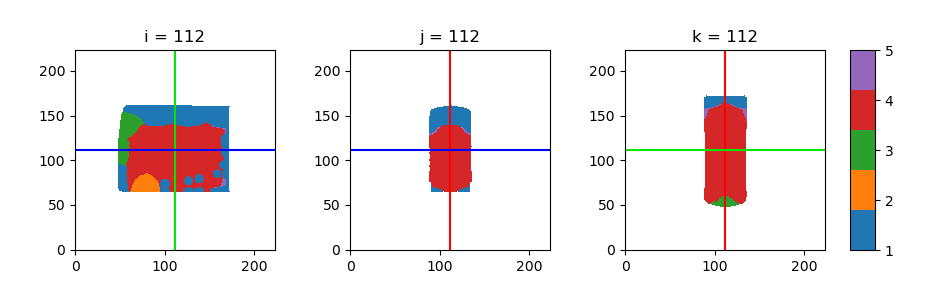

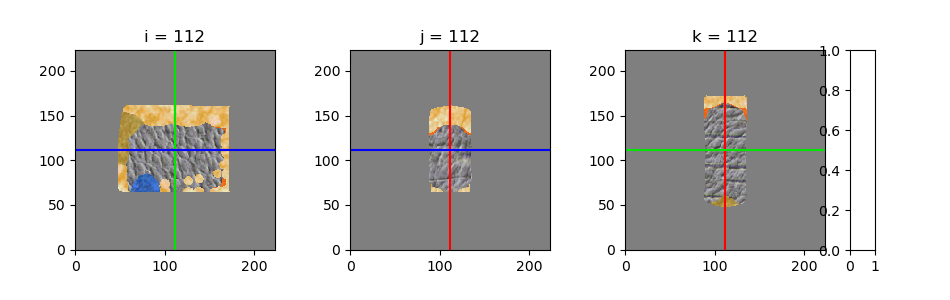

In [60]:
%autoreload
import project.visual.matplotlib as mpl_viz

mask = project.core.fileio.load_nibabel(ex.paths['material_mask']).get_fdata()
image = project.core.fileio.load_nibabel(ex.paths['input_image']).get_fdata()

print(image[mask > 0].mean())
print(image[mask > 0].std())

mpl_viz.SliceViewer(mask, **mpl_viz.get_color_kws('material', n_labels=5))
mpl_viz.SliceViewer((image + 1)/2)

In [61]:
rgb = (image.ndim == 4 and image.shape[-1] == 3)
rgb

True

In [62]:
train_config = config['training'].copy()
project.core.utils.pprint(train_config, 2, 100)

dict(len=9)
├── 'task':            dict(len=3)
|   ├── 'inputs':  list(len=1)
|   ├── 'targets': list(len=3)
|   └── 'losses':  dict(len=1)
├── 'split':           dict(len=4)
|   ├── 'key':        'category'
|   ├── 'test_ratio': 0.2
|   ├── 'val_ratio':  0.1
|   └── 'seed':       0
├── 'transform':       dict(len=5)
|   ├── 'normalize':  True
|   ├── 'image_mean': 1.0
|   ├── 'image_std':  1.0
|   ├── 'apply_mask': True
|   └── 'do_augment': True
├── 'loader':          dict(len=6)
|   ├── 'batch_size':         1
|   ├── 'shuffle':            True
|   ├── 'num_workers':        2
|   ├── 'persistent_workers': True
|   ├── 'prefetch_factor':    2
|   └── 'pin_memory':         True
├── 'model':           dict(len=2)
|   ├── 'backbone':    dict(len=11)
|   └── 'param_specs': dict(len=3)
├── 'physics_adapter': dict(len=4)
|   ├── 'default_nu':    0.4
|   ├── 'default_rho':   1000
|   ├── 'scalar_degree': 1
|   └── 'vector_degree': 1
├── 'pde_solver':      dict(len=3)
|   ├── '_class':      

In [63]:
seed = 1234
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [64]:
import project.training
split_kws = train_config['split']
train_ex, test_ex, val_ex = project.training.split_on_metadata(examples, **split_kws)

len(train_ex), len(test_ex), len(val_ex)

Splitting examples
Test categories: {'ChestOfDrawers', 'Computer', 'Cabinet', 'CurioCabinet'}
Test subjects:   {'wss.1029fd5d71a06ea32ea98d69e91ba870', 'wss.18efc77e6837f7d311e76965808086c8'}
Train subjects: {'wss.101354f9d8dede686f7b08d9de913afe', 'wss.102a6b7809f4e51813842bc8ef6fe18', 'wss.100f39dce7690f59efb94709f30ce0d2', 'wss.133c16fc6ca7d77676bb31db0358e9c6', 'wss.18f4a9ed04407da57bd55ed4ce08f048', 'wss.107637b6bdf8129d4904d89e9169817b', 'wss.13b48456dad49f8762edbb9e1af21a03'}
Val subjects:   {'wss.1644df5fbb3b926029e82c550aa06a9d'}


(7, 2, 1)

In [65]:
transform_kws = train_config['transform'].copy()

transform_kws['normalize']  = True
transform_kws['image_mean'] = 0.0
transform_kws['image_std']  = 1.0
transform_kws['apply_mask'] = True

transform_kws['do_augment']   = True
transform_kws['rand_rotate']  = True
transform_kws['rand_reflect'] = True
transform_kws['sigma_trans']  = 4.0

transform_kws

{'normalize': True,
 'image_mean': 0.0,
 'image_std': 1.0,
 'apply_mask': True,
 'do_augment': True,
 'rand_rotate': True,
 'rand_reflect': True,
 'sigma_trans': 4.0}

In [66]:
%autoreload
import project.datasets.torch

use_cache = len(examples) < 100
train_set = project.datasets.torch.TorchDataset(train_ex, use_cache=use_cache, rgb=rgb, **transform_kws)
test_set = project.datasets.torch.TorchDataset(test_ex, use_cache=use_cache, rgb=rgb, **transform_kws)
val_set = project.datasets.torch.TorchDataset(val_ex, use_cache=use_cache, rgb=rgb, **transform_kws)

In [67]:
loader_kws = train_config['loader'].copy()
loader_kws = {'batch_size': 1, 'num_workers': 0}
loader_kws

{'batch_size': 1, 'num_workers': 0}

In [68]:
collate_fn = project.datasets.torch.collate_fn
train_loader = torch.utils.data.DataLoader(train_set, collate_fn=collate_fn, **loader_kws)

if test_set:
    test_loader = torch.utils.data.DataLoader(test_set, collate_fn=collate_fn, **loader_kws)
else:
    test_loader = None

if val_set:
    val_loader = torch.utils.data.DataLoader(val_set, collate_fn=collate_fn, **loader_kws)
else:
    val_loader = None


In [69]:
import project.training

task_kws = train_config['task'].copy()

task_kws['inputs']  = ['image']
task_kws['targets'] = ['E', 'nu', 'rho']
task_kws['losses']  = {'E': 'sim'}

task = project.training.TaskSpec(rgb=rgb, **task_kws)

Inputs:  ['image']
Targets: ['E', 'nu', 'rho']
Losses:  {'E': 'sim'}


In [70]:
import copy
model_kws = copy.deepcopy(train_config['model'])

project.core.utils.pprint(model_kws, 3, 20)

dict(len=2)
├── 'backbone':    dict(len=11)
|   ├── '_class':        'UNet3Dv2'
|   ├── 'out_channels':  16
|   ├── 'conv_channels': 16
|   ├── 'n_conv_units':  2
|   ├── 'n_sub_levels':  2
|   ├── 'kernel_size':   3
|   ├── 'relu_leak':     0.1
|   ├── 'norm_type':     'group'
|   ├── 'num_groups':    4
|   ├── 'pooling_type':  'max'
|   └── 'upsample_mode': 'trilinear'
└── 'param_specs': dict(len=3)
    ├── 'E':   dict(len=5)
    |   ├── 'mode': 'log10'
    |   ├── 'mean': 3.4863
    |   ├── 'std':  0.3271
    |   ├── 'min':  0.0
    |   └── 'max':  6.0
    ├── 'nu':  dict(len=3)
    |   ├── 'mode': 'logit'
    |   ├── 'min':  0.0
    |   └── 'max':  0.5
    └── 'rho': dict(len=3)
        ├── 'mode': 'log10'
        ├── 'mean': 3.0
        └── 'std':  0.1


In [71]:
%autoreload
import project.models
model = project.models.build_model(task, model_kws)
model

MultiTaskModel(
  (backbone): UNet3Dv2(
    (enc): ConvBlock3D(
      (unit0): ConvUnit3D(
        (conv): Conv3d(3, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same, bias=False, padding_mode=replicate)
        (norm): GroupNorm(4, 16, eps=1e-05, affine=True)
        (act): LeakyReLU(negative_slope=0.1, inplace=True)
      )
      (unit1): ConvUnit3D(
        (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same, bias=False, padding_mode=replicate)
        (norm): GroupNorm(4, 16, eps=1e-05, affine=True)
        (act): LeakyReLU(negative_slope=0.1, inplace=True)
      )
    )
    (down): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (sub): UNet3Dv2(
      (enc): ConvBlock3D(
        (unit0): ConvUnit3D(
          (conv): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same, bias=False, padding_mode=replicate)
          (norm): GroupNorm(4, 32, eps=1e-05, affine=True)
          (act): LeakyReLU(negative_slo

In [72]:
project.models.count_params(model)

backbone.enc.unit0.conv.weight                     1296	(16, 3, 3, 3, 3)
backbone.enc.unit0.norm.weight                     16	(16,)
backbone.enc.unit0.norm.bias                       16	(16,)
backbone.enc.unit1.conv.weight                     6912	(16, 16, 3, 3, 3)
backbone.enc.unit1.norm.weight                     16	(16,)
backbone.enc.unit1.norm.bias                       16	(16,)
backbone.sub.enc.unit0.conv.weight                 13824	(32, 16, 3, 3, 3)
backbone.sub.enc.unit0.norm.weight                 32	(32,)
backbone.sub.enc.unit0.norm.bias                   32	(32,)
backbone.sub.enc.unit1.conv.weight                 27648	(32, 32, 3, 3, 3)
backbone.sub.enc.unit1.norm.weight                 32	(32,)
backbone.sub.enc.unit1.norm.bias                   32	(32,)
backbone.sub.sub.enc.unit0.conv.weight             55296	(64, 32, 3, 3, 3)
backbone.sub.sub.enc.unit0.norm.weight             64	(64,)
backbone.sub.sub.enc.unit0.norm.bias               64	(64,)
backbone.sub.sub.enc.unit1.c

472163

In [73]:
pde_solver_kws = train_config['pde_solver'].copy()
pde_solver_kws['relative_loss'] = True
pde_solver_kws

{'_class': 'WarpFEMSolver', 'relative_loss': True, 'tv_reg_weight': 0.0001}

In [74]:
import project.physics

pde_solver_cls = pde_solver_kws.pop('_class')

physics_adapter = project.physics.PhysicsAdapter(
    pde_solver_cls=pde_solver_cls,
    pde_solver_kws=pde_solver_kws,
    **train_config['physics_adapter']
)
physics_adapter

In [75]:
import torch.optim
optimizer_kws = train_config['optimizer'].copy()
optimizer_kws['lr'] = 1e-3
optimizer_cls = getattr(torch.optim, optimizer_kws.pop('_class'))
optimizer = optimizer_cls(model.parameters(), **optimizer_kws)

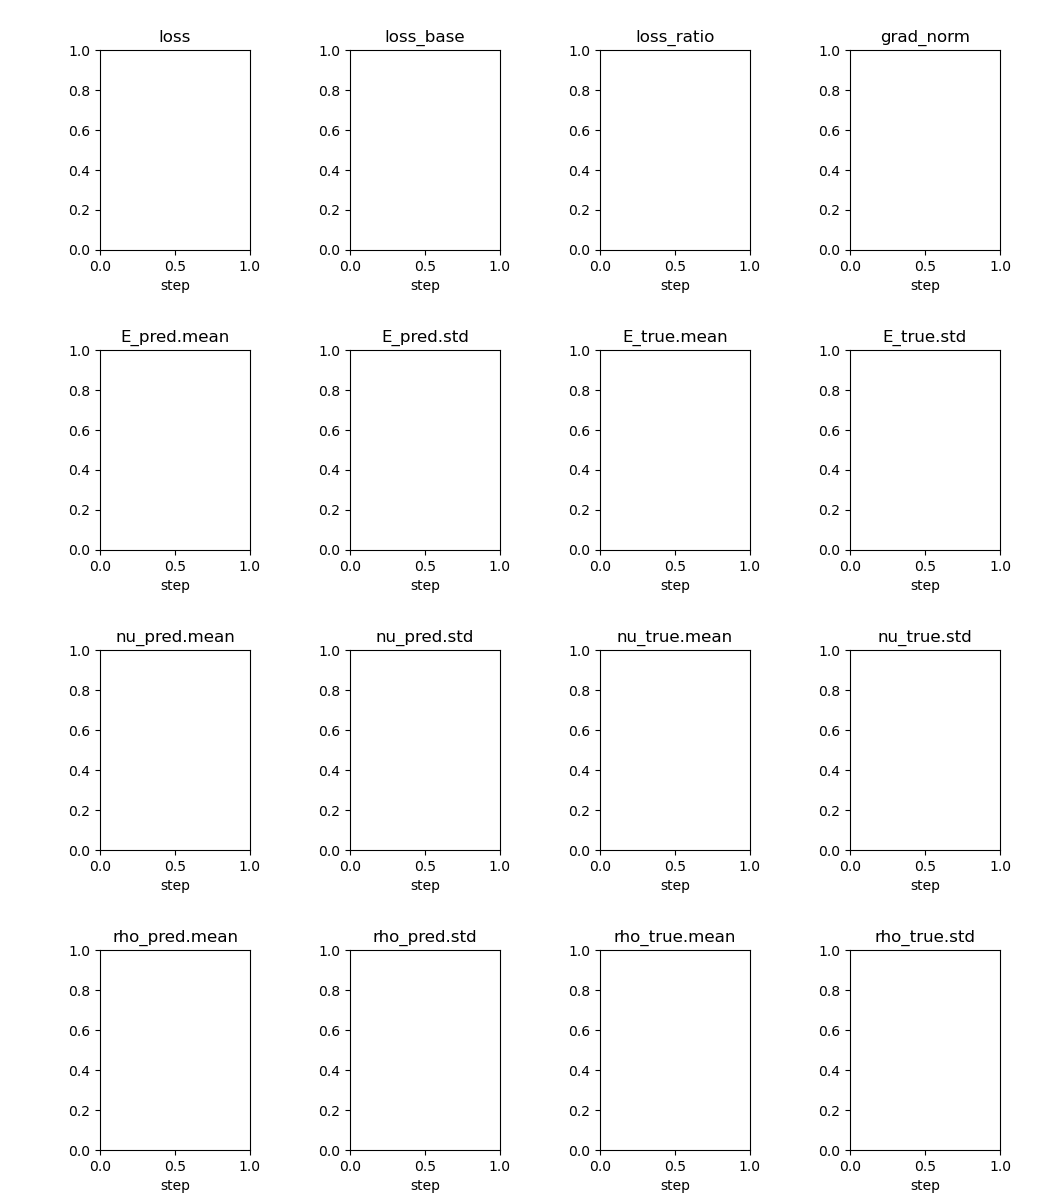

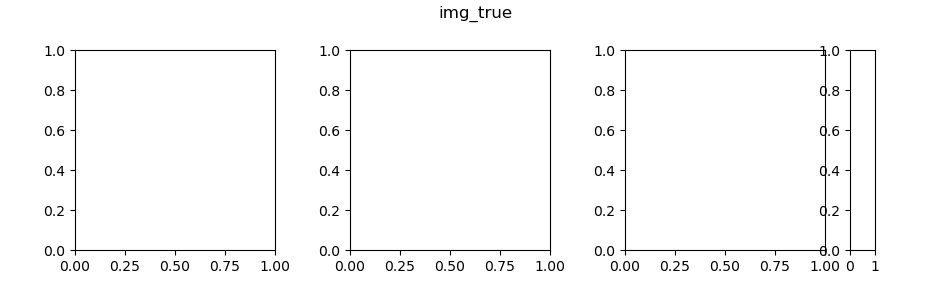

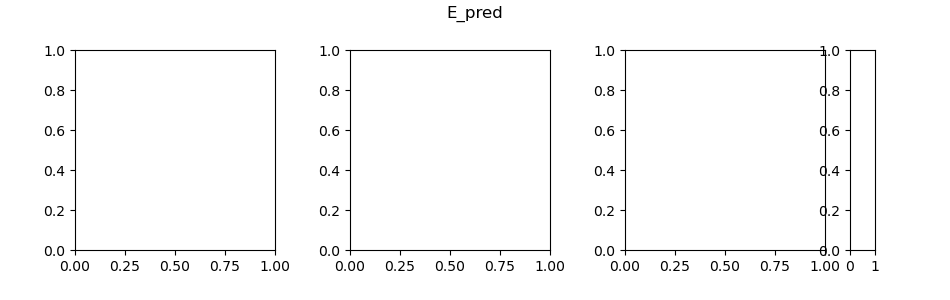

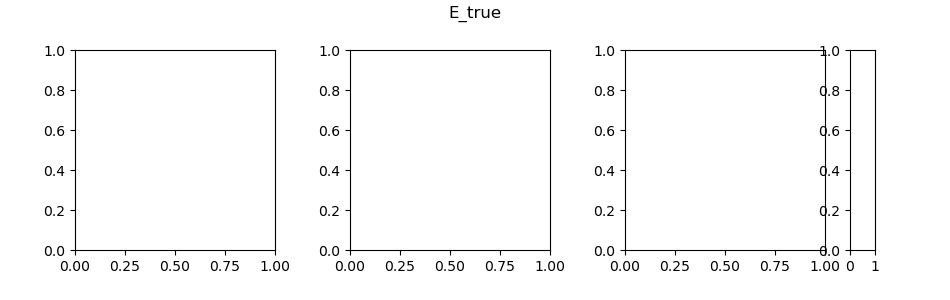

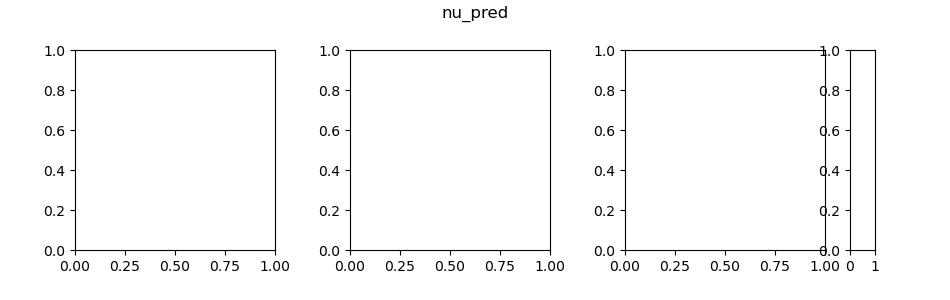

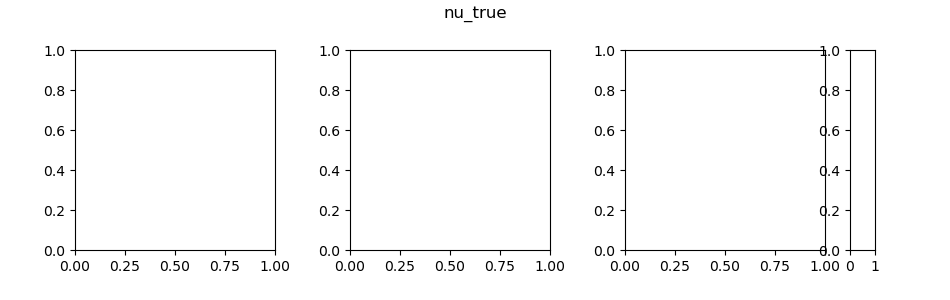

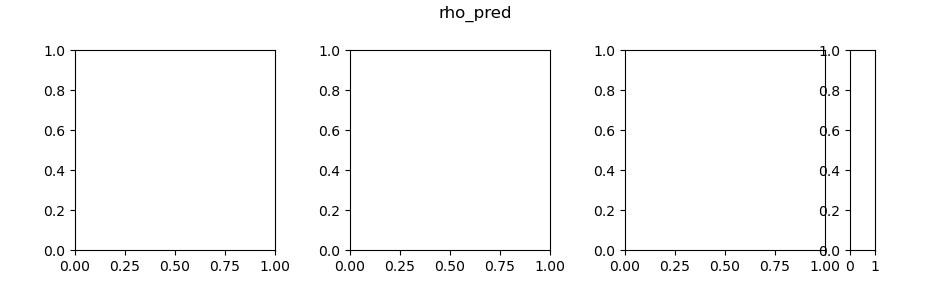

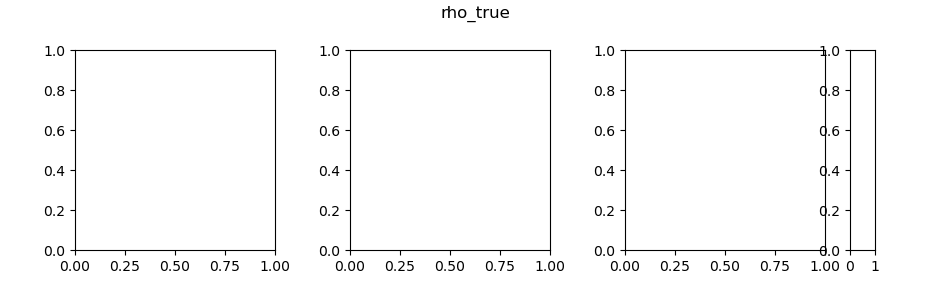

In [78]:
%autoreload
import project.training
import project.evaluation

trainer_kws = train_config['trainer'].copy()

torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

callbacks = [
    project.evaluation.LoggerCallback(task.metric_keys),
    project.evaluation.PlotterCallback(task.metric_keys),
    project.evaluation.ViewerCallback(task.viewer_keys, apply_mask=True),
    project.evaluation.EvaluatorCallback(),
    project.evaluation.TimerCallback(),
]

trainer = project.training.Trainer(
    task=task,
    model=model,
    optimizer=optimizer,
    physics_adapter=physics_adapter,
    train_loader=train_loader,
    test_loader=test_loader,
    val_loader=val_loader,
    callbacks=callbacks
)

In [77]:
%autoreload
#trainer.load_state(epoch=0)
trainer.train(num_epochs=100, val_every=1)

Start training
Start epoch 0
Saving checkpoints/checkpoint00000.pt
Start epoch 0 val phase
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1644df5fbb3b926029e82c550aa06a9d/images/mask_regions_uniform-seed_min_max-0.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1644df5fbb3b926029e82c550aa06a9d/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1644df5fbb3b926029e82c550aa06a9d/meshes/mask_regions_uniform-seed_min_max-0_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1644df5fbb3b926029e82c550aa06a9d/fields/mask_regions_uniform-seed_elastic.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1644df5fbb3b926029e82c550aa06a9d/fields/mask_regions_uniform-seed_density.nii.gz
[Epoch 0 | Val batch 0] start
load_data: {'t_delta': 1.8614, 'curr_all

/ocean/projects/asc170022p/mtragoza/lung-project/notebooks/shapenet/../../project/evaluation.py:194: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_xlabel('step')
/ocean/projects/asc170022p/mtragoza/lung-project/notebooks/shapenet/../../project/evaluation.py:196: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.grid(True)


plotter: {'t_delta': 1.0911, 'curr_alloc': 0.0172, 'curr_rsvd': 18.3379, 'peak_alloc': 0.0177, 'peak_rsvd': 18.3379}


/ocean/projects/asc170022p/mtragoza/lung-project/notebooks/shapenet/../../project/visual/matplotlib.py:103: UserWarning: Adding colorbar to a different Figure <Figure size 950x300 with 4 Axes> than <Figure size 950x300 with 4 Axes> which fig.colorbar is called on.
  plt.colorbar(self.im_k, cax=self.cbar_ax)


viewer: {'t_delta': 0.686, 'curr_alloc': 0.0172, 'curr_rsvd': 18.3379, 'peak_alloc': 0.0172, 'peak_rsvd': 18.3379}


KeyboardInterrupt: 

In [ ]:
ctx = list(physics_adapter._cache.values())[0]
params = physics_adapter.get_material_params(ctx)
physics_adapter.get_canonical_params(ctx, params)